In [1]:
import cira

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [2]:
portfolio = cira.Portfolio()

In [3]:
import pandas as pd 
import numpy as np
from typing import List, Dict

In [4]:
from datetime import datetime

assets_symbols = ["MSFT", "TSLA", "AMZN"]
stk_hist_data = {}
IS_CACHED = True

for SYMBOL in assets_symbols:
    SYM_HIST_FILE = f"./{SYMBOL}.csv"

    stk = cira.Stock(SYMBOL)

    if not IS_CACHED:
        start = datetime(2015, 7, 1)
        end = datetime(2023, 7, 1)
        stk.save_historical_data(SYM_HIST_FILE, start, end)
    
    data = stk.load_historical_data(SYM_HIST_FILE)
    stk_hist_data[SYMBOL] = data



In [5]:

df = pd.DataFrame()

for sym, hist in stk_hist_data.items():
    df[sym] = hist["close"]

df["CASH"] = 1.0

df

,MSFT,TSLA,AMZN,CASH
timestamp,,,,
2016-01-04 05:00:00+00:00,54.80,223.41,636.99,1.0
2016-01-05 05:00:00+00:00,55.05,223.43,633.79,1.0
2016-01-06 05:00:00+00:00,54.05,219.04,632.65,1.0
2016-01-07 05:00:00+00:00,52.17,215.65,607.94,1.0
2016-01-08 05:00:00+00:00,52.33,211.00,607.05,1.0
...,...,...,...,...
2023-06-26 04:00:00+00:00,328.60,241.05,127.33,1.0
2023-06-27 04:00:00+00:00,334.57,250.21,129.18,1.0
2023-06-28 04:00:00+00:00,335.85,256.24,129.04,1.0


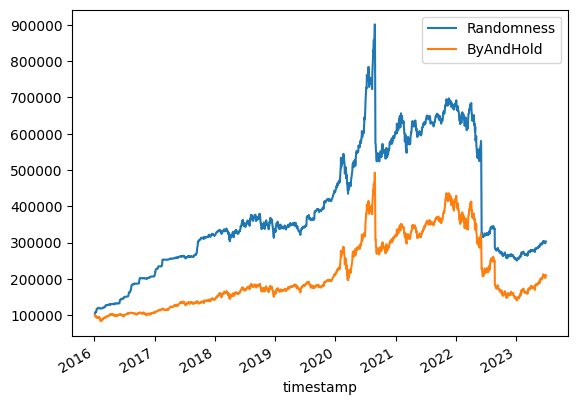

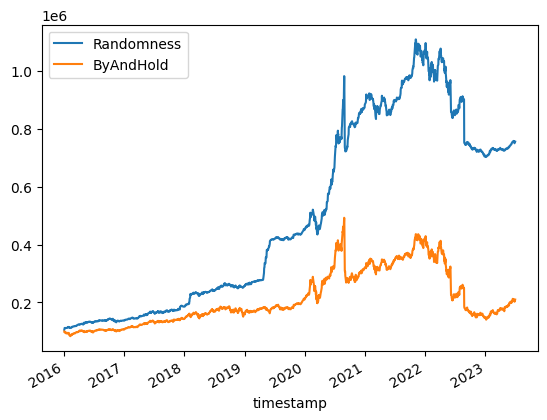

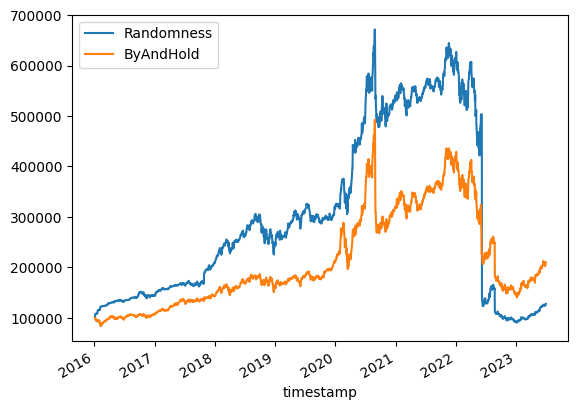

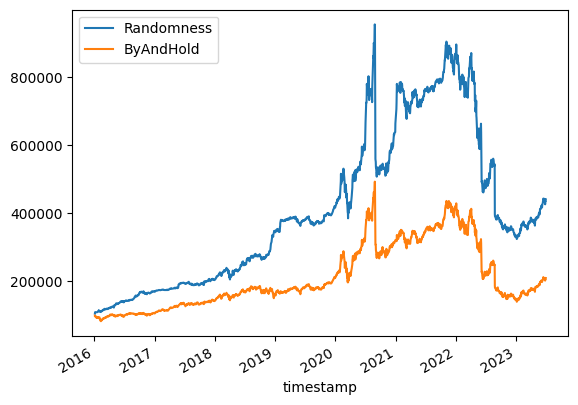

In [6]:
from cira.strategy.strategy import Randomness
from cira.strategy.backtest import back_test_against_buy_and_hold

for _ in range(4):
    back_test_against_buy_and_hold(Randomness(-8,8), df, df, 100_000, True).plot()
